Cargado: network_traffic_classification_300.csv

Primeras filas:
   packets_per_sec  avg_bytes_per_packet  burstiness  label label_name
0       952.853325            221.406736    0.841786      2       ddos
1       359.797652            678.619161    0.262384      0     benign
2       575.784963            292.131748    0.230803      1  port_scan
3       286.050997            674.525841    0.315543      0     benign
4       607.959172            282.906956    0.263264      1  port_scan 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   packets_per_sec       300 non-null    float64
 1   avg_bytes_per_packet  300 non-null    float64
 2   burstiness            300 non-null    float64
 3   label                 300 non-null    int64  
 4   label_name            300 non-null    object 
dtypes: float64(3), int64(1), object(1)
memory

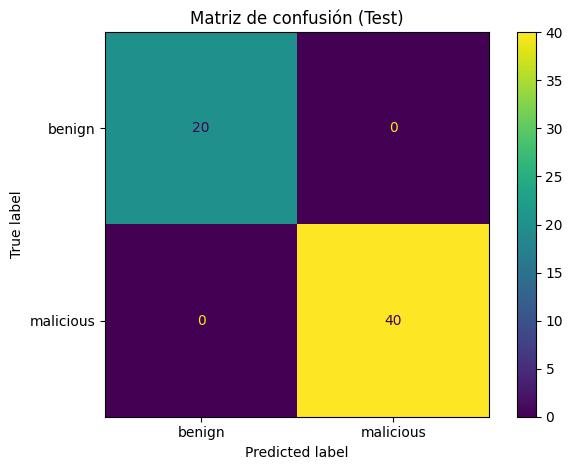

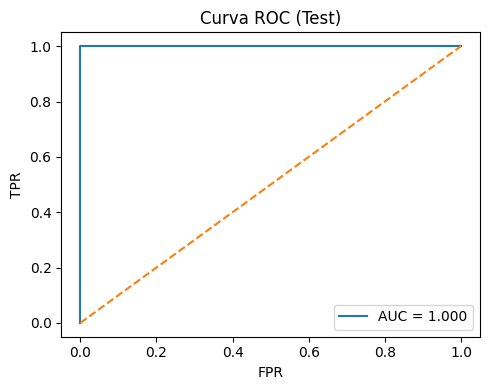

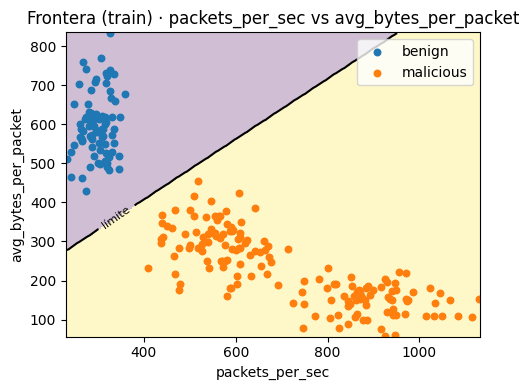

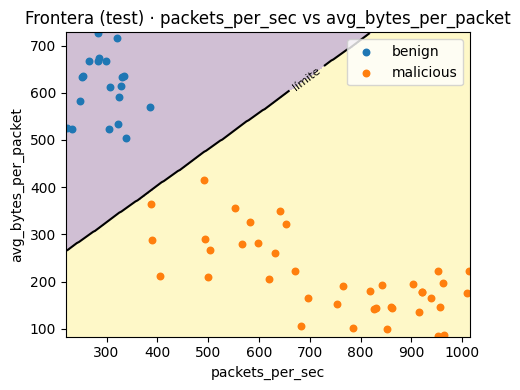

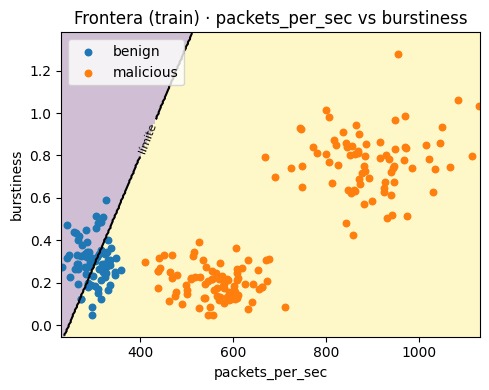

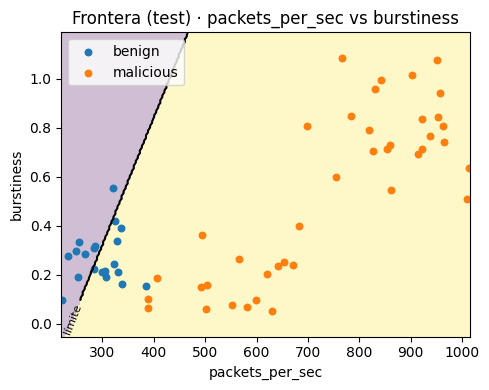

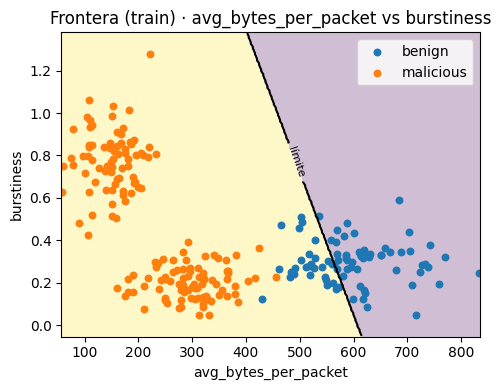

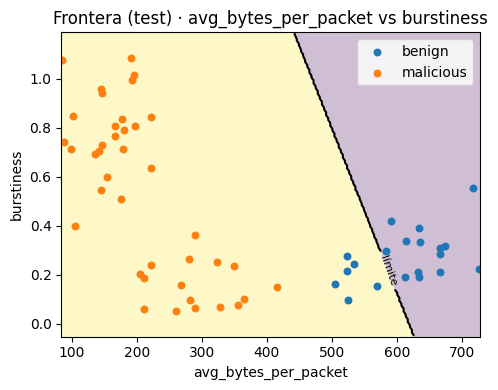


Errores en test: 0
Sin errores en test (o conjunto de test pequeño).


In [2]:

import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc,
    classification_report
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


CSV_CANDIDATES = [
    "network_traffic_classification_300.csv",
    "/content/network_traffic_classification_300.csv",
]

df = None
for p in CSV_CANDIDATES:
    if os.path.exists(p):
        df = pd.read_csv(p)
        print(f"Cargado: {p}")
        break

if df is None:
    try:
        from google.colab import files
        print("No se encontró el CSV. Sube el archivo `network_traffic_classification_300.csv`")
        uploaded = files.upload()
        name = list(uploaded.keys())[0]
        df = pd.read_csv(name)
        print(f"Cargado vía upload: {name}")
    except Exception as e:
        raise FileNotFoundError("No se encontró el CSV. Sube el archivo y vuelve a ejecutar esta celda.") from e

print("\nPrimeras filas:")
print(df.head(), "\n")
print(df.info(), "\n")


print("Forma:", df.shape)
print("\nValores nulos por columna:\n", df.isna().sum())
if 'label' in df.columns:
    print("\nClases y recuentos (label):\n", df['label'].value_counts())
if 'label_name' in df.columns:
    print("\nClases y recuentos (label_name):\n", df['label_name'].value_counts())

feature_cols = [c for c in ['packets_per_sec','avg_bytes_per_packet','burstiness'] if c in df.columns]
print("\nEstadísticos descriptivos de features:\n", df[feature_cols].describe())


df = df.copy()

if 'label_name' in df.columns:

    df['target_bin'] = df['label_name'].isin(['port_scan', 'ddos']).astype(int)
elif 'label' in df.columns:

    df['target_bin'] = df['label'].isin([1, 2]).astype(int)
else:
    raise ValueError("No se encontró ni 'label_name' ni 'label' en el CSV.")

print("\nRecuento tras binarizar (target_bin):\n", df['target_bin'].value_counts())


if df['target_bin'].nunique() < 2:
    raise ValueError(
        "Tras binarizar, solo hay una clase en 'target_bin'. "
        "Revisa que la binarización apunte a las columnas correctas."
    )


X = df[feature_cols].values
y = df['target_bin'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print("\nShapes -> Train:", X_train.shape, " Test:", X_test.shape)
print("Proporción malicioso (1) en train/test:", y_train.mean(), y_test.mean())


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(probability=True, random_state=RANDOM_STATE))
])

param_grid = [
    {"svc__kernel": ["linear"], "svc__C": [0.1, 1, 10, 100]},
    {"svc__kernel": ["rbf"], "svc__C": [0.1, 1, 10, 100], "svc__gamma": ["scale", 0.01, 0.1, 1]},
    {"svc__kernel": ["poly"], "svc__degree": [2, 3, 4], "svc__C": [0.1, 1, 10, 100], "svc__gamma": ["scale", 0.01, 0.1, 1]},
]

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1",
    cv=skf,
    n_jobs=-1,
    refit=True,
    verbose=0
)

grid.fit(X_train, y_train)
print("\nMejor F1 en CV:", grid.best_score_)
print("Mejores hiperparámetros:", grid.best_params_)
best_model = grid.best_estimator_


y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\nMétricas en test:")
print("  Accuracy :", accuracy_score(y_test, y_pred))
print("  Precision:", precision_score(y_test, y_pred))
print("  Recall   :", recall_score(y_test, y_pred))
print("  F1       :", f1_score(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred, target_names=["benign","malicious"]))

cm = confusion_matrix(y_test, y_pred, labels=[0,1])
ConfusionMatrixDisplay(cm, display_labels=["benign","malicious"]).plot(values_format='d')
plt.title("Matriz de confusión (Test)")
plt.tight_layout()
plt.show()


fpr, tpr, thr = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Curva ROC (Test)")
plt.legend()
plt.tight_layout()
plt.show()


def plot_decision_regions_2d(model, X, y, x_idx, y_idx, title=""):
    x_min, x_max = X[:, x_idx].min()-0.1, X[:, x_idx].max()+0.1
    y_min, y_max = X[:, y_idx].min()-0.1, X[:, y_idx].max()+0.1
    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    grid2d = np.c_[XX.ravel(), YY.ravel()]

    X_avg = X.mean(axis=0)
    X_grid3d = np.tile(X_avg, (grid2d.shape[0], 1))
    X_grid3d[:, x_idx] = grid2d[:, 0]
    X_grid3d[:, y_idx] = grid2d[:, 1]

    Z = model.predict_proba(X_grid3d)[:, 1]
    Z = Z.reshape(XX.shape)

    plt.figure(figsize=(5,4))
    plt.pcolormesh(XX, YY, (Z > 0.5), shading='auto', alpha=0.25)
    cs = plt.contour(XX, YY, Z, levels=[0.5], linestyles=['-'], colors=['k'])
    plt.clabel(cs, inline=True, fontsize=8, fmt="límite")

    for lab in [0,1]:
        mask = y == lab
        plt.scatter(X[mask, x_idx], X[mask, y_idx], s=22, label=("malicious" if lab==1 else "benign"))
    names = feature_cols
    plt.xlabel(names[x_idx]); plt.ylabel(names[y_idx]); plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

pairs_idx = [(0,1),(0,2),(1,2)]
for a, b in pairs_idx:
    plot_decision_regions_2d(best_model, X_train, y_train, a, b, title=f"Frontera (train) · {feature_cols[a]} vs {feature_cols[b]}")
    plot_decision_regions_2d(best_model, X_test, y_test, a, b, title=f"Frontera (test) · {feature_cols[a]} vs {feature_cols[b]}")


mis = np.where(y_test != y_pred)[0]
print(f"\nErrores en test: {len(mis)}")
if len(mis) > 0:
    err_df = pd.DataFrame(
        np.c_[X_test[mis], y_test[mis], y_pred[mis]],
        columns=feature_cols + ["y_true","y_pred"]
    )
    print(err_df.head(20).to_string(index=False))
else:
    print("Sin errores en test (o conjunto de test pequeño).")
